# Pretrained VGG16 on Invasive species from different Downsampling method for image preprocessing

- The model relies on VGG-16 pretrained model, with `include_top=False`. On top of that, a nn with (1) Dense layer 256 neurons, (2) Output layer 1 neuron, with sigmoid classification.
- This model is brutal, in the sense that, all paramaters including vgg-16, are trainable. This makes the model too heavy to train, (2~3 days on a 4-core desktop!)
- Data augmentation is applied upon traing every batch.

In [10]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import cv2
import math
from glob import glob
import os
import sys
# using cv2.INTER_AREA, cv2.INTER_LINEAR, cv2.INTER_LANCZOS4
interpolation = cv2.INTER_LANCZOS4

## Preprocess training images

### image file_paths

In [2]:
master = pd.read_csv("../input/train_labels.csv")

img_path = "../input/train/"

y = []
file_paths = []
for i in range(len(master)):
    file_paths.append( img_path + str(master.iloc[i, 0]) +'.jpg' ) # .ix same as .iloc
    y.append(master.iloc[i,1])
y = np.array(y)

### Preprocessing pipline with specific downsampling method

resize -> centering -> cropping

In [2]:
def centering_image(img):
    size = [256,256]
    
    img_size = img.shape[:2]
    
    # centering
    row = (size[1] - img_size[0]) // 2
    col = (size[0] - img_size[1]) // 2
    resized = np.zeros(list(size) + [img.shape[2]], dtype=np.uint8)
    resized[row:(row + img.shape[0]), col:(col + img.shape[1])] = img

    return resized

In [4]:
X = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()
    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))
    img = cv2.resize(img, dsize=tile_size, interpolation=interpolation)

    #centering
    img = centering_image(img)

    #out put 224*224px 
    img = img[16:240, 16:240]
    img = img.astype('float32')
    img /= 255.0
    X.append(img)

X = np.array(X)

 ../input/train/2295.jpg from total 2295 images

## Train-Test splitting

In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=2017)

print('X_train', X_train.shape)
print('y_train', y_train.shape)
print('X_val', X_val.shape)
print('y_val', y_val.shape)

X_train (1836, 224, 224, 3)
y_train (1836,)
X_val (459, 224, 224, 3)
y_val (459,)


## Using Keras VGG-16 pretrained model

In [6]:
from keras.models import Sequential, Model, load_model
from keras import applications
from keras import optimizers
from keras.layers import Dropout, Flatten, Dense

img_rows, img_cols, img_channel = 224, 224, 3

base_model = applications.VGG16(weights='imagenet', include_top=False, 
                                input_shape=(img_rows, img_cols, img_channel))

Using TensorFlow backend.


In [7]:
x = base_model.output
x = Flatten()(x)
x = Dense(256, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=base_model.input, outputs=predictions)
model.compile(loss='binary_crossentropy', optimizer=optimizers.SGD(lr=1e-4, momentum=0.9), metrics=['accuracy'])

In [8]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

### Model fitting with data augmentation

In [9]:
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint

batch_size = 32
epochs = 40

train_datagen = ImageDataGenerator(
        rotation_range=30, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True)
train_datagen.fit(X_train)


history = model.fit_generator(
    train_datagen.flow(X_train, y_train, batch_size=batch_size),
    steps_per_epoch=X_train.shape[0] // batch_size,
    epochs=epochs,
    verbose=2,
    validation_data=(X_val, y_val),
    callbacks=[ModelCheckpoint('VGG16-transferlearning'+str(interpolation)+'.model', monitor='val_acc', save_best_only=True)])

Epoch 1/40
112s - loss: 0.5476 - acc: 0.7045 - val_loss: 0.3674 - val_acc: 0.8562
Epoch 2/40
107s - loss: 0.3171 - acc: 0.8626 - val_loss: 0.2685 - val_acc: 0.9150
Epoch 3/40
104s - loss: 0.2203 - acc: 0.9125 - val_loss: 0.1869 - val_acc: 0.9368
Epoch 4/40
104s - loss: 0.2075 - acc: 0.9167 - val_loss: 0.1474 - val_acc: 0.9499
Epoch 5/40
104s - loss: 0.1721 - acc: 0.9371 - val_loss: 0.1509 - val_acc: 0.9564
Epoch 6/40
104s - loss: 0.1575 - acc: 0.9434 - val_loss: 0.1137 - val_acc: 0.9586
Epoch 7/40
102s - loss: 0.1683 - acc: 0.9413 - val_loss: 0.1814 - val_acc: 0.9499
Epoch 8/40
104s - loss: 0.1394 - acc: 0.9523 - val_loss: 0.1002 - val_acc: 0.9739
Epoch 9/40
103s - loss: 0.1153 - acc: 0.9567 - val_loss: 0.0922 - val_acc: 0.9695
Epoch 10/40
103s - loss: 0.1173 - acc: 0.9602 - val_loss: 0.1040 - val_acc: 0.9717
Epoch 11/40
105s - loss: 0.1000 - acc: 0.9624 - val_loss: 0.0943 - val_acc: 0.9760
Epoch 12/40
103s - loss: 0.1230 - acc: 0.9567 - val_loss: 0.1701 - val_acc: 0.9521
Epoch 13/40
1

## Model prediction on validation images

In [10]:
model = load_model('VGG16-transferlearning'+str(interpolation)+'.model')
y_val_pred = model.predict(X_val)

### Prediction accuracy

In [11]:
y_val_pred_cls = (y_val_pred > 0.5).astype('int')
acc = np.sum(y_val == y_val_pred_cls.reshape(-1)) / y_val.shape[0]
print('Val accuracy: {:.6f}'.format(acc))

Val accuracy: 0.989107


### ROC curve

In [12]:
from sklearn.metrics import roc_curve, auc
def roc_plot(y_test, y_pred_proba):
    fpr, tpr, _ = roc_curve(y_test, y_pred_proba)
    roc_auc = auc(fpr, tpr)
    
    plt.figure()
    lw = 2
    plt.plot(fpr, tpr, color='darkorange', lw=lw, label='ROC curve (area = %0.6f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")
    plt.show()

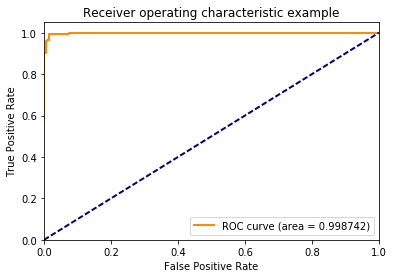

In [13]:
roc_plot(y_val, y_val_pred.reshape(-1))

## Conclusion

- cv2.INTER_LINEAR
    - acc: 0.984749
    - roc: 0.998239
- cv2.INTER_AREA
    - acc: 0.989107
    - roc: 0.998742
- cv2.INTER_LANCZOS4
    - acc: 0.986928
    - roc: 0.998065

cv2.INTER_AREA downsampling gives the best results.

## Predict on test images

In [11]:
sample_submission = pd.read_csv("../input/sample_submission.csv")
img_path = "../input/test/"

test_names = []
file_paths = []

for i in range(len(sample_submission)):
    test_names.append(sample_submission.iloc[i,0])
    file_paths.append( img_path + str(int(sample_submission.iloc[i,0])) +'.jpg' )

test_names = np.array(test_names)

In [12]:
X_test = []
for i, file_path in enumerate(file_paths):
    sys.stdout.write("\r {0} from total {1} images".format(file_path, len(file_paths)))
    sys.stdout.flush()

    #read image
    img = cv2.imread(file_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

    #resize
    if(img.shape[0] > img.shape[1]):
        tile_size = (int(img.shape[1]*256/img.shape[0]),256)
    else:
        tile_size = (256, int(img.shape[0]*256/img.shape[1]))

    #centering
    img = centering_image(cv2.resize(img, dsize=tile_size, interpolation=interpolation))
    
    #out put 224*224px 
    img = img[16:240, 16:240]
    img = img.astype('float32')
    img /= 255.0
    X_test.append(img)

X_test = np.array(X_test)

 ../input/test/1531.jpg from total 1531 images

In [13]:
model = load_model('VGG16-transferlearning'+str(interpolation)+'.model')
y_test_pred = model.predict(X_test)

In [14]:
def submission_to_csv(test_preds, file_path):
    sample_submission = pd.read_csv("../input/sample_submission.csv")
    for i, name in enumerate(test_names):
        sample_submission.loc[sample_submission['name'] == name, 'invasive'] = test_preds[i]
    sample_submission.to_csv(file_path, index=False)

In [15]:
submission_to_csv(test_preds=y_test_pred, file_path='submit_subsample_lanczos4.csv')

## Conclusion on test submission

- `cv2.INTER_LINEAR`: 0.98536
- `cv2.INTER_AREA` : 0.98457
- `cv2.INTER_LANCZOS4` : 0.98813

Best performance obtained on Lanczos downsampling method.